
<a id='egm-policy-iter'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Optimal Growth III: The Endogenous Grid Method

## Contents

- [Optimal Growth III: The Endogenous Grid Method](#Optimal-Growth-III:-The-Endogenous-Grid-Method)  
  - [Overview](#Overview)  
  - [Key Idea](#Key-Idea)  
  - [Implementation](#Implementation)  
  - [Speed](#Speed)  

## Overview

We solved the stochastic optimal growth model using

1. [value function iteration](optgrowth.html)  
1. [Euler equation based time iteration](coleman_policy_iter.html)  


We found time iteration to be significantly more accurate at each step.

In this lecture we’ll look at an ingenious twist on the time iteration technique called the **endogenous grid method** (EGM).

EGM is a numerical method for implementing policy iteration invented by [Chris Carroll](http://www.econ2.jhu.edu/people/ccarroll/).

It is a good example of how a clever algorithm can save a massive amount of computer time.

(Massive when we multiply saved CPU cycles on each implementation times the number of implementations worldwide)

The original reference is [[Car06]](../zreferences.html#carroll2006).

## Key Idea

Let’s start by reminding ourselves of the theory and then see how the numerics fit in.

### Theory

Take the model set out in [the time iteration lecture](coleman_policy_iter.html), following the same terminology and notation.

The Euler equation is


<a id='equation-egm-euler'></a>
$$
(u'\circ c^*)(y)
= \beta \int (u'\circ c^*)(f(y - c^*(y)) z) f'(y - c^*(y)) z \phi(dz) \tag{1}
$$

As we saw, the Coleman operator is a nonlinear operator $ K $ engineered so that $ c^* $ is a fixed point of $ K $.

It takes as its argument a continuous strictly increasing consumption policy $ g \in \Sigma $.

It returns a new function $ Kg $,  where $ (Kg)(y) $ is the $ c \in (0, \infty) $ that solves


<a id='equation-egm-coledef'></a>
$$
u'(c)
= \beta \int (u' \circ g) (f(y - c) z ) f'(y - c) z \phi(dz) \tag{2}
$$

### Exogenous Grid

As discussed in [the lecture on time iteration](coleman_policy_iter.html), to implement the method on a computer we need numerical approximation.

In particular, we represent a policy function by a set of values on a finite grid.

The function itself is reconstructed from this representation when necessary, using interpolation or some other method.

[Previously](coleman_policy_iter.html), to obtain a finite representation of an updated consumption policy we

- fixed a grid of income points $ \{y_i\} $  
- calculated the consumption value $ c_i $ corresponding to each
  $ y_i $ using [(2)](#equation-egm-coledef) and a root finding routine  


Each $ c_i $ is then interpreted as the value of the function $ K g $ at $ y_i $.

Thus, with the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ Kg $ via approximation.

Iteration then continues…

### Endogenous Grid

The method discussed above requires a root finding routine to find the
$ c_i $ corresponding to a given income value $ y_i $.

Root finding is costly because it typically involves a significant number of
function evaluations.

As pointed out by Carroll [[Car06]](../zreferences.html#carroll2006), we can avoid this if
$ y_i $ is chosen endogenously.

The only assumption required is that $ u' $ is invertible on $ (0, \infty) $.

The idea is this:

First we fix an *exogenous* grid $ \{k_i\} $ for capital ($ k = y - c $).

Then we obtain  $ c_i $ via


<a id='equation-egm-getc'></a>
$$
c_i =
(u')^{-1}
\left\{
    \beta \int (u' \circ g) (f(k_i) z ) \, f'(k_i) \, z \, \phi(dz)
\right\} \tag{3}
$$

where $ (u')^{-1} $ is the inverse function of $ u' $.

Finally, for each $ c_i $ we set $ y_i = c_i + k_i $.

It is clear that each $ (y_i, c_i) $ pair constructed in this manner satisfies [(2)](#equation-egm-coledef).

With the points $ \{y_i, c_i\} $ in hand, we can reconstruct $ Kg $ via approximation as before.

The name EGM comes from the fact that the grid $ \{y_i\} $ is  determined **endogenously**.

## Implementation

Let’s implement this version of the Coleman operator and see how it performs.

### The Operator

Here’s an implementation of $ K $ using EGM as described above.

### Setup

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using BenchmarkTools, Interpolations, Parameters, Plots, QuantEcon, Random, Roots
gr(fmt = :png);

In [3]:
function coleman_egm(g, k_grid, β, u′, u′_inv, f, f′, shocks)

    # Allocate memory for value of consumption on endogenous grid points
    c = similar(k_grid)

    # Solve for updated consumption value
    for (i, k) in enumerate(k_grid)
        vals = u′.(g.(f(k) * shocks)) .* f′(k) .* shocks
        c[i] = u′_inv(β * mean(vals))
    end

    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = LinearInterpolation(y,c, extrapolation_bc=Line())
    Kg_f(x) = Kg(x)
    return Kg_f
end

coleman_egm (generic function with 1 method)

Note the lack of any root finding algorithm.

We’ll also run our original implementation, which uses an exogenous grid and requires root finding, so we can perform some comparisons

In [4]:
function K!(Kg, g, grid, β, u′, f, f′, shocks)

    # This function requires the container of the output value as argument Kg

    # Construct linear interpolation object #
    g_func = LinearInterpolation(grid, g, extrapolation_bc = Line())

    # solve for updated consumption value #
    for (i, y) in enumerate(grid)
        function h(c)
            vals = u′.(g_func.(f(y - c) * shocks)) .* f′(y - c) .* shocks
            return u′(c) - β * mean(vals)
        end
        Kg[i] = find_zero(h, (1e-10, y - 1e-10))
    end
    return Kg
end

# The following function does NOT require the container of the output value as argument
K(g, grid, β, u′, f, f′, shocks) =
    K!(similar(g), g, grid, β, u′, f, f′, shocks)

K (generic function with 1 method)

Let’s test out the code above on some example parameterizations, after the following imports.

### Testing on the Log / Cobb–Douglas case

As we [did for value function iteration](optgrowth.html) and [time iteration](coleman_policy_iter.html), let’s start by testing our method with the log-linear benchmark.

The first step is to bring in the model that we used in the [Coleman policy function iteration](coleman_policy_iter.html)

In [5]:
# model

Model = @with_kw (α = 0.65, # productivity parameter
                  β = 0.95, # discount factor
                  γ = 1.0,  # risk aversion
                  μ = 0.0,  # lognorm(μ, σ)
                  s = 0.1,  # lognorm(μ, σ)
                  grid_min = 1e-6, # smallest grid point
                  grid_max = 4.0,  # largest grid point
                  grid_size = 200, # grid size
                  u = γ == 1 ? log : c->(c^(1-γ)-1)/(1-γ), # utility function
                  u′ = c-> c^(-γ), # u'
                  f = k-> k^α, # production function
                  f′ = k -> α*k^(α-1), # f'
                  grid = range(grid_min, grid_max, length = grid_size)) # grid

#5 (generic function with 2 methods)

Next we generate an instance

In [6]:
mlog = Model(); # Log Linear model

We also need some shock draws for Monte Carlo integration

In [7]:
Random.seed!(42); # For reproducible behavior.

shock_size = 250     # Number of shock draws in Monte Carlo integral
shocks = exp.(mlog.μ .+ mlog.s * randn(shock_size));

As a preliminary test, let’s see if $ K c^* = c^* $, as implied by the theory

In [8]:
c_star(y) = (1 - mlog.α * mlog.β) * y

# some useful constants
ab = mlog.α * mlog.β
c1 = log(1 - ab) / (1 - mlog.β)
c2 = (mlog.μ + mlog.α * log(ab)) / (1 - mlog.α)
c3 = 1 / (1 - mlog.β)
c4 = 1 / (1 - ab)

v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y)

v_star (generic function with 1 method)

In [9]:
function verify_true_policy(m, shocks, c_star)
    k_grid = m.grid
    c_star_new = coleman_egm(c_star, k_grid, m.β, m.u′, m.u′, m.f, m.f′, shocks)

    plt = plot()
    plot!(plt, k_grid, c_star.(k_grid), lw = 2, label = "optimal policy c*")
    plot!(plt, k_grid, c_star_new.(k_grid), lw = 2, label = "Kc*")
    plot!(plt, legend = :topleft)
end

verify_true_policy (generic function with 1 method)

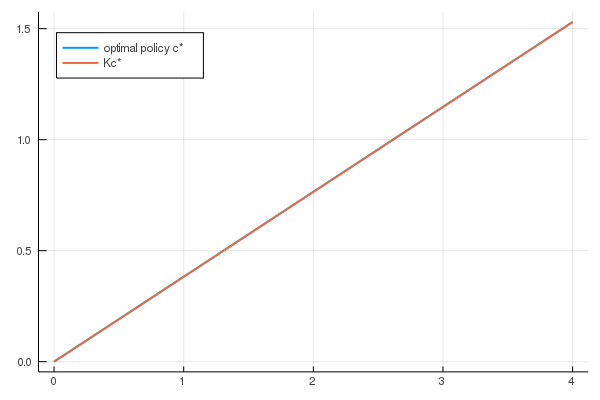

In [10]:
verify_true_policy(mlog, shocks, c_star)

Notice that we’re passing u′ to coleman_egm twice.

The reason is that, in the case of log utility, $ u'(c) = (u')^{-1}(c) = 1/c $.

Hence u′ and u′_inv are the same.

We can’t really distinguish the two plots.

In fact it’s easy to see that the difference is essentially zero:

In [11]:
c_star_new = coleman_egm(c_star, mlog.grid, mlog.β, mlog.u′,
                         mlog.u′, mlog.f, mlog.f′, shocks)
maximum(abs(c_star_new(g) - c_star(g)) for g in mlog.grid)

1.3322676295501878e-15

Next let’s try iterating from an arbitrary initial condition and see if we
converge towards $ c^* $.

Let’s start from the consumption policy that eats the whole pie: $ c(y) = y $

In [12]:
n = 15
function check_convergence(m, shocks, c_star, g_init, n_iter)
    k_grid = m.grid
    g = g_init
    plt = plot()
    plot!(plt, m.grid, g.(m.grid),
          color = RGBA(0,0,0,1), lw = 2, alpha = 0.6, label = "initial condition c(y) = y")
    for i in 1:n_iter
        new_g = coleman_egm(g, k_grid, m.β, m.u′, m.u′, m.f, m.f′, shocks)
        g = new_g
        plot!(plt, k_grid, new_g.(k_grid), alpha = 0.6, color = RGBA(0,0,(i / n_iter), 1),
              lw = 2, label = "")
    end

    plot!(plt, k_grid, c_star.(k_grid),
          color = :black, lw = 2, alpha = 0.8, label = "true policy function c*")
    plot!(plt, legend = :topleft)
end

check_convergence (generic function with 1 method)

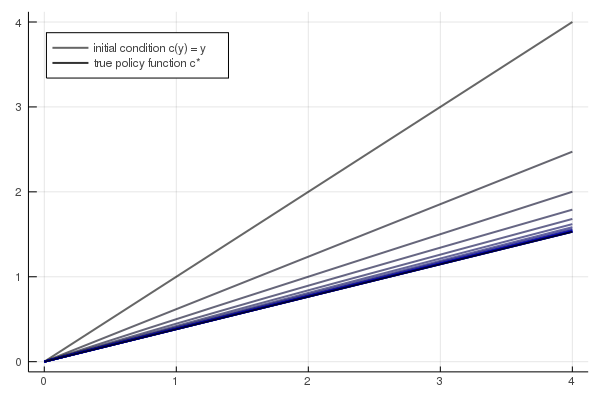

In [13]:
check_convergence(mlog, shocks, c_star, identity, n)

We see that the policy has converged nicely, in only a few steps.

## Speed

Now let’s compare the clock times per iteration for the standard Coleman
operator (with exogenous grid) and the EGM version.

We’ll do so using the CRRA model adopted in the exercises of the [Euler equation time iteration lecture](coleman_policy_iter.html).

Here’s the model and some convenient functions

In [14]:
mcrra = Model(α = 0.65, β = 0.95, γ = 1.5)
u′_inv(c) = c^(-1 / mcrra.γ)

u′_inv (generic function with 1 method)

Here’s the result

In [15]:
crra_coleman(g, m, shocks) = K(g, m.grid, m.β, m.u′, m.f, m.f′, shocks)
crra_coleman_egm(g, m, shocks) = coleman_egm(g, m.grid, m.β, m.u′,
                                             u′_inv, m.f, m.f′, shocks)
function coleman(m = m, shocks = shocks; sim_length = 20)
    g = m.grid
    for i in 1:sim_length
        g = crra_coleman(g, m, shocks)
    end
    return g
end
function egm(m, g = identity, shocks = shocks; sim_length = 20)
    for i in 1:sim_length
        g = crra_coleman_egm(g, m, shocks)
    end
    return g.(m.grid)
end

egm (generic function with 3 methods)

In [16]:
@benchmark coleman($mcrra)

BenchmarkTools.Trial: 
  memory estimate:  1.03 GiB
  allocs estimate:  615012
  --------------
  minimum time:     7.217 s (1.58% GC)
  median time:      7.217 s (1.58% GC)
  mean time:        7.217 s (1.58% GC)
  maximum time:     7.217 s (1.58% GC)
  --------------
  samples:          1
  evals/sample:     1

In [17]:
@benchmark egm($mcrra)

BenchmarkTools.Trial: 
  memory estimate:  18.50 MiB
  allocs estimate:  76226
  --------------
  minimum time:     140.864 ms (0.00% GC)
  median time:      144.582 ms (0.00% GC)
  mean time:        145.670 ms (1.43% GC)
  maximum time:     154.178 ms (3.36% GC)
  --------------
  samples:          35
  evals/sample:     1

We see that the EGM version is about 30 times faster.

At the same time, the absence of numerical root finding means that it is
typically more accurate at each step as well.